# Mathematical Underpinnings - Lab 7

In [56]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [1]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return (np.dot(mu2-mu1, np.dot(np.linalg.inv(Sigma2), mu2 - mu1)) + np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1))) \
        - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)) - mu1.shape[0])/2

In [3]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = -np.log(np.linalg.det(Sigma1))/2 - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i,:] - mu1)), x[i,:] - mu1)/2
        st = np.log(np.linalg.det(Sigma2))/2 + np.dot(np.dot(np.linalg.inv(Sigma2), x[i,:] - mu2), x[i,:] - mu2)/2
        res[i] = ft+st
    return res

### b)

In [63]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)
n = 10000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))
x, y

(array([[-0.16951434,  0.30996999, -0.14981152, -0.73918335, -0.1991851 ],
        [ 0.89113818,  0.69989092, -0.51578384, -1.86863494,  0.11439438],
        [-0.31587142, -0.95818001, -0.87250164, -0.49876356, -0.00492717],
        ...,
        [-0.19603205, -0.37138904, -1.46262861, -0.23124573,  1.73116639],
        [ 0.18534956, -0.43692344,  0.65644023,  0.48440355, -2.69220529],
        [-1.65951681,  1.97593057,  0.91150839,  0.40118934, -0.10283711]]),
 array([1., 1., 1., ..., 0., 0., 0.]))

In [64]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [65]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042573

In [66]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.138969272308646

### c)

In [67]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [68]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [70]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 0s 10ms/step - loss: -0.0139 - val_loss: -0.0341
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0469 - val_loss: -0.0617
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: -0.0641 - val_loss: -0.0766
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0728 - val_loss: -0.0852
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0785 - val_loss: -0.0906
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0819 - val_loss: -0.0946
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0845 - val_loss: -0.0977
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0868 - val_loss: -0.1005
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0890 - val_loss: -0.1030
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: -0.0909 - val_lo

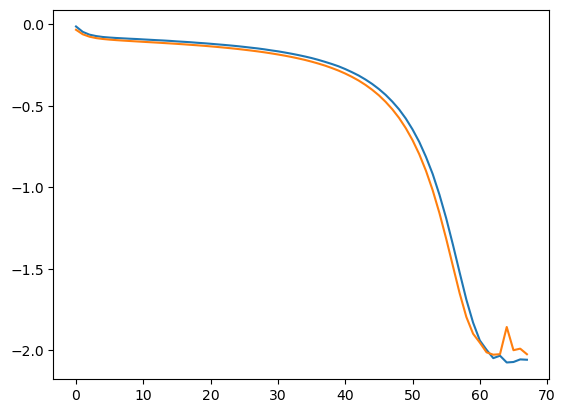

In [71]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [72]:
t_x_pred = model.predict(x)[:,0]

625/625 [==============================] - 0s 711us/step


In [73]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

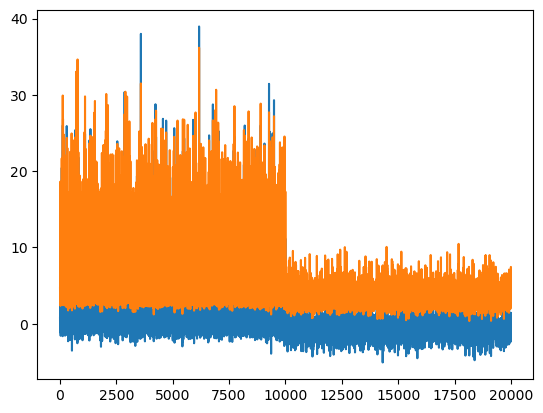

In [74]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

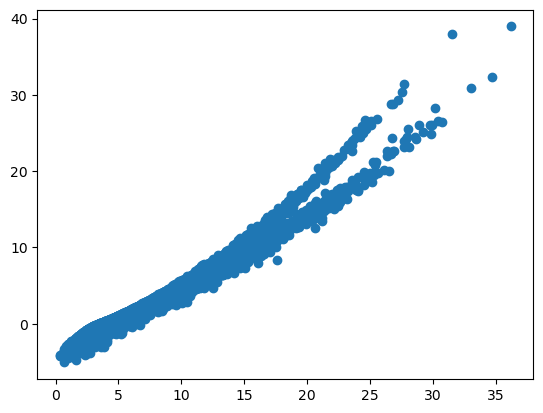

In [75]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [76]:
DV_fun(y, t_x_pred)

2.051683731207163

In [77]:
DV_fun(y, t_x_opt)

2.138969272308646

In [78]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))

In [79]:
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:,0]

625/625 [==============================] - 0s 696us/step


In [80]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

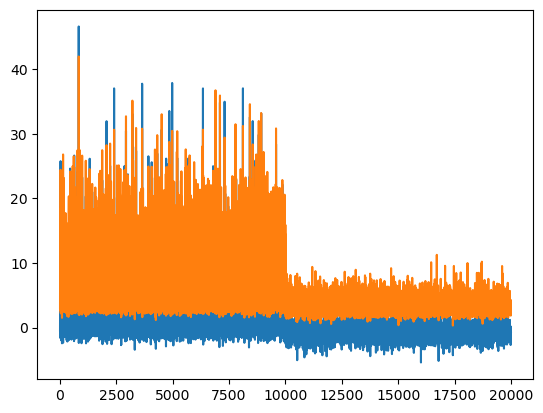

In [81]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

In [82]:
DV_fun(y_new, t_x_pred)

2.116773585208173

In [83]:
DV_fun(y_new, t_x_opt)

2.260347940655771

### f)

In [84]:
def NWJ_loss(y_true, y_pred):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(y_pred, y_true)) / n1
    second_term = tf.math.reduce_sum(tf.math.multiply(
        tf.math.exp(tf.subtract(y_pred, tf.convert_to_tensor(1.0))),
        tf.subtract(tf.convert_to_tensor(1.0), y_true))) / n2
    return -(first_term - second_term)

In [123]:
def NWJ_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.sum(np.exp(t-1)*(1-y))/n2

In [113]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=3e-3)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=NWJ_loss)

In [114]:
hist = model.fit(x_train, y_train, epochs=300, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/300
15/15 [==============================] - 0s 10ms/step - loss: 0.0828 - val_loss: 0.0265
Epoch 2/300
15/15 [==============================] - 0s 3ms/step - loss: 0.0201 - val_loss: 0.0088
Epoch 3/300
15/15 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: -0.0054
Epoch 4/300
15/15 [==============================] - 0s 3ms/step - loss: -0.0075 - val_loss: -0.0174
Epoch 5/300
15/15 [==============================] - 0s 3ms/step - loss: -0.0178 - val_loss: -0.0271
Epoch 6/300
15/15 [==============================] - 0s 3ms/step - loss: -0.0262 - val_loss: -0.0351
Epoch 7/300
15/15 [==============================] - 0s 3ms/step - loss: -0.0332 - val_loss: -0.0418
Epoch 8/300
15/15 [==============================] - 0s 3ms/step - loss: -0.0390 - val_loss: -0.0474
Epoch 9/300
15/15 [==============================] - 0s 3ms/step - loss: -0.0438 - val_loss: -0.0520
Epoch 10/300
15/15 [==============================] - 0s 3ms/step - loss: -0.0480 - val_loss: -

15/15 [==============================] - 0s 3ms/step - loss: -0.1120 - val_loss: -0.1211
Epoch 82/300
15/15 [==============================] - 0s 3ms/step - loss: -0.1130 - val_loss: -0.1221
Epoch 83/300
15/15 [==============================] - 0s 3ms/step - loss: -0.1139 - val_loss: -0.1229
Epoch 84/300
15/15 [==============================] - 0s 3ms/step - loss: -0.1149 - val_loss: -0.1240
Epoch 85/300
15/15 [==============================] - 0s 3ms/step - loss: -0.1159 - val_loss: -0.1252
Epoch 86/300
15/15 [==============================] - 0s 3ms/step - loss: -0.1167 - val_loss: -0.1259
Epoch 87/300
15/15 [==============================] - 0s 3ms/step - loss: -0.1178 - val_loss: -0.1272
Epoch 88/300
15/15 [==============================] - 0s 3ms/step - loss: -0.1189 - val_loss: -0.1282
Epoch 89/300
15/15 [==============================] - 0s 3ms/step - loss: -0.1200 - val_loss: -0.1295
Epoch 90/300
15/15 [==============================] - 0s 3ms/step - loss: -0.1215 - val_loss: -

Epoch 161/300
15/15 [==============================] - 0s 4ms/step - loss: -0.3104 - val_loss: -0.3263
Epoch 162/300
15/15 [==============================] - 0s 3ms/step - loss: -0.3169 - val_loss: -0.3327
Epoch 163/300
15/15 [==============================] - 0s 3ms/step - loss: -0.3239 - val_loss: -0.3399
Epoch 164/300
15/15 [==============================] - 0s 4ms/step - loss: -0.3307 - val_loss: -0.3472
Epoch 165/300
15/15 [==============================] - 0s 4ms/step - loss: -0.3381 - val_loss: -0.3546
Epoch 166/300
15/15 [==============================] - 0s 4ms/step - loss: -0.3453 - val_loss: -0.3625
Epoch 167/300
15/15 [==============================] - 0s 3ms/step - loss: -0.3534 - val_loss: -0.3704
Epoch 168/300
15/15 [==============================] - 0s 3ms/step - loss: -0.3611 - val_loss: -0.3788
Epoch 169/300
15/15 [==============================] - 0s 3ms/step - loss: -0.3700 - val_loss: -0.3877
Epoch 170/300
15/15 [==============================] - 0s 3ms/step - loss

15/15 [==============================] - 0s 3ms/step - loss: -1.9848 - val_loss: -1.8607
Epoch 240: early stopping


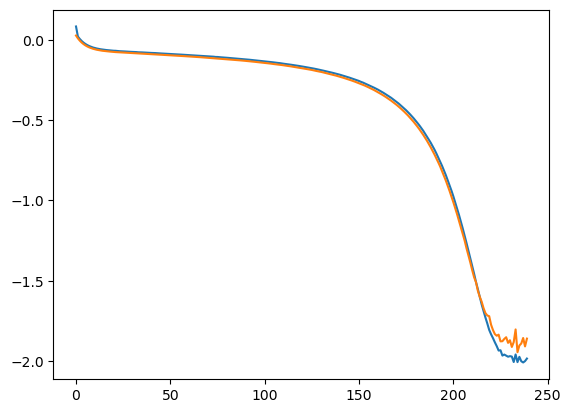

In [115]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [116]:
t_x_pred = model.predict(x)[:,0]

625/625 [==============================] - 0s 680us/step


In [117]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

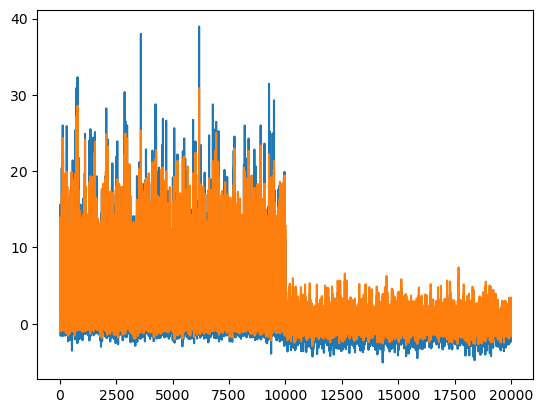

In [118]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

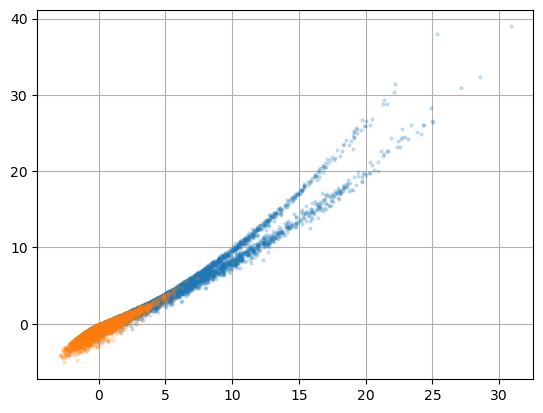

In [119]:
plt.plot(t_x_pred[y==1], t_x_opt[y==1], "o", alpha=0.2, markersize=2)
plt.plot(t_x_pred[y==0], t_x_opt[y==0], "o", alpha=0.2, markersize=2)
plt.grid()
plt.show()

In [126]:
NWJ_fun(y, t_x_pred)

1.991929947705567

In [127]:
NWJ_fun(y, t_x_opt)

1.7547513774571102

New data:

In [129]:
t_x_pred = model.predict(x_new)[:, 0]

625/625 [==============================] - 0s 703us/step


In [130]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

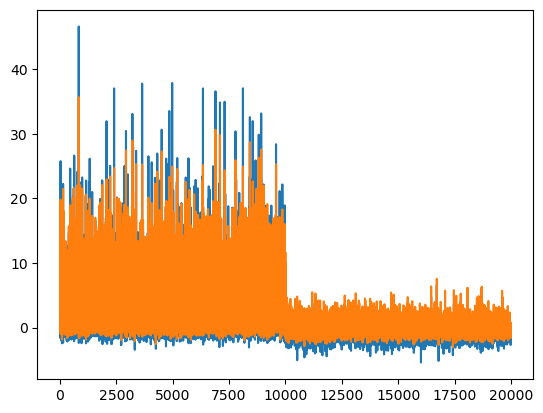

In [133]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

In [131]:
NWJ_fun(y_new, t_x_pred)

2.102069700236246

In [132]:
NWJ_fun(y_new, t_x_opt)

1.8251361948888565